In [1]:
# imports
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers 
from tensorflow.keras import utils
utils.set_random_seed(42)
import numpy as np
np.random.seed(20)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# unzip the data
zip = zipfile.ZipFile('/content/satellite-image-classification-dataset.zip', 'r')
zip.extractall('/content')
zip.close()

In [3]:
# loading training & validation data
train_data, val_data = utils.image_dataset_from_directory(
    directory = '/content/data',
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    color_mode='rgb',
    validation_split=0.3,
    subset='both',
    batch_size=32, seed=18)

Found 5631 files belonging to 4 classes.
Using 3942 files for training.
Using 1689 files for validation.


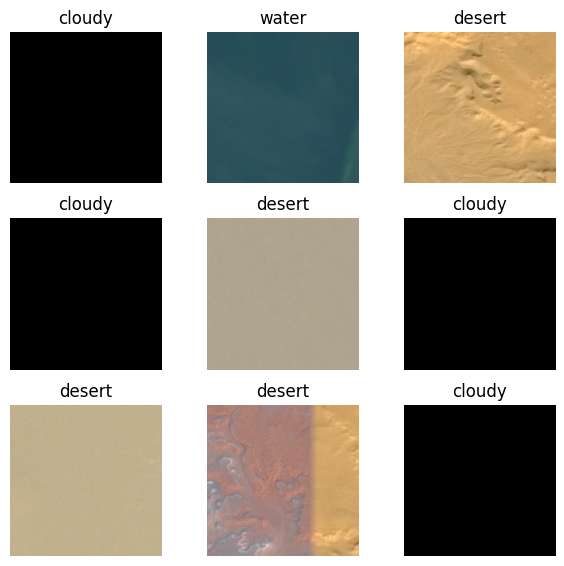

In [4]:
# looking at some images with class labels
plt.figure(figsize=(6, 6))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.tight_layout(h_pad=.9, w_pad=.6)
    plt.axis("off")

**For looking at images with int labels:**
```
plt.figure(figsize=(6,6))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.tight_layout(h_pad=.9, w_pad=.6)
    plt.axis('off')
```

In [5]:
# rescaling images
rescale = layers.Rescaling(1.0/255)
def preprocess(image, label):
  return rescale(image), label
train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)

In [6]:
# data augmentation
flip = layers.RandomFlip('horizontal', seed=32)
contrast = layers.RandomContrast(.3, seed=32)
def data_aug(image, label):
  image = flip(image)
  image = contrast(image)
  return image, label
train_data = train_data.map(data_aug)

In [7]:
# building input pipeline; batch size is already set in image_dataset_from_directory
train_data = train_data.shuffle(len(train_data)).cache().prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(tf.data.AUTOTUNE)

In [8]:
# defining a model architecture
model = Sequential([
    
    # convo base
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    # flattening 
    layers.Flatten(),
    
    # fully connected layer
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [9]:
# getting a summary of the configuration
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 re_lu (ReLU)                (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [10]:
# compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [11]:
# training the model
history = model.fit(train_data, validation_data=val_data, epochs=4, verbose=1)

Epoch 1/4
124/124 [==============================] - 32s 86ms/step - loss: 0.3763 - accuracy: 0.8141 - val_loss: 0.1945 - val_accuracy: 0.9224
Epoch 2/4
124/124 [==============================] - 8s 67ms/step - loss: 0.2216 - accuracy: 0.9016 - val_loss: 0.1708 - val_accuracy: 0.9266
Epoch 3/4
124/124 [==============================] - 8s 66ms/step - loss: 0.1814 - accuracy: 0.9231 - val_loss: 0.1631 - val_accuracy: 0.9319
Epoch 4/4
124/124 [==============================] - 8s 66ms/step - loss: 0.1729 - accuracy: 0.9264 - val_loss: 0.1482 - val_accuracy: 0.9384


In [12]:
# model evaluation
score = model.evaluate(val_data, verbose=0)
print('Accuracy:', round((score[1] * 100), 2))

Accuracy: 93.84


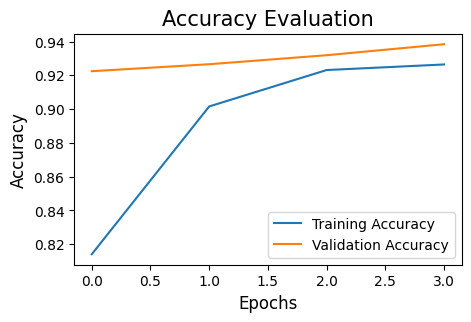

In [13]:
# accuracy evaluation
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evaluation', size=15)
plt.xlabel('Epochs', size=12)
plt.ylabel('Accuracy', size=12)
plt.legend();

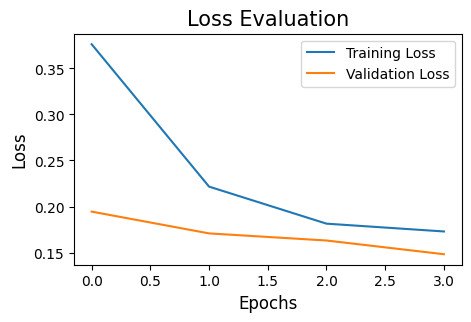

In [14]:
# loss evaluation
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evaluation', size=15)
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.legend();